# Import de librairies et données

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
# from scipy import integrate
from sympy import integrate
from scipy.linalg import eig

In [59]:
nat_freq = np.loadtxt('P2024_f_Part4.txt')
modes_data = np.loadtxt('P2024_Modes_Part4.txt')

x = sp.symbols('x')

---

# Paramètres du modèle

In [60]:
L = 0.8
a = 0.2
length = L+2*a

e = 0.15
t = 0.01
d = 0.25
rho = 7850
A = e**2 - (e-2*t)**2
E = 210e9
I = (e**4 - (e-2*t)**4)/12

M_mot = 75.2
M_dv = 75

J_B = 1
J_D = 10
k_1l = 1e4  # N/m
k_1r = 1e9  # Nm/rad attention
k_2l = 1e5
k_2r = 1e4

---

# Méthode d'approximation de Rayleigh-Ritz


## Fonction d'approximation
 "p" = polynomiale (fonctionne)<br>
 "h" = harmonique / sin (ne fonctionne pas)

In [61]:
def phi(x, n, form="p"):
    # h ne marche pas

    if form == "p":

        f = (x/length)**n

    if form == "h":

        f = sp.cos(n*np.pi*x/length)

    return f


# phi en metres


# d phi/ dx = theta en radians avec les petits angles

Matrice de masses


In [62]:
def Mass(N):

    B = L/2
    D = L + a
    M = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            M[i, j] = (integrate(rho * A * phi(x, i) * phi(x, j), (x, 0, length))
                       + M_mot * phi(B, i) * phi(B, j)
                       + M_mot * d**2 *
                       sp.diff(phi(x, i), x).subs(x, B) *
                       sp.diff(phi(x, j), x).subs(x, B)
                       + J_B * sp.diff(phi(x, i), x).subs(x, B) *
                       sp.diff(phi(x, j), x).subs(x, B)
                       + M_dv * phi(D, i) * phi(D, j)
                       + J_D * sp.diff(phi(x, i), x).subs(x, D) * sp.diff(phi(x, j), x).subs(x, D))

    return M

Matrices de raideurs

In [63]:
def Stiff(N):

    A_pos = 0
    C = L
    K = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            K[i, j] = (integrate(E * I * sp.diff(phi(x, i), x, x) * sp.diff(phi(x, j), x, x), (x, 0, length))
                       + k_1l * phi(A_pos, i) * phi(A_pos, j)
                       + k_1r * sp.diff(phi(x, i), x).subs(x, A_pos) *
                       sp.diff(phi(x, j), x).subs(x, A_pos)
                       + k_2l * phi(C, i) * phi(C, j)
                       + k_2r * sp.diff(phi(x, i), x).subs(x, C) * sp.diff(phi(x, j), x).subs(x, C))

    return K

---

# Calcul des fréquences propres et erreurs

In [64]:
freq_wanted = 1
N_min = freq_wanted
N_max = 10

freq_matrix = np.full((N_max-N_min+1, 4), float('inf'))
error_matrix = np.full((N_max-N_min+1, 4), float('inf'))
# error_matrix[n,f] = erreur ( en %) sur la f-ieme fréquence naturelle pour N fonctions de base

for N in range(N_min, N_max+1):

    M = Mass(N)
    K = Stiff(N)

    eigvals, eigvecs = eig(K, M)
    omega = np.sort(np.abs(np.sqrt(eigvals))) / (2 * np.pi)
    print(omega[:5])

    # Remplissage de la matrice de fréquences
    for f in range(len(nat_freq)):
        if (N > f):
            freq_matrix[N-N_min, f] = omega[f]

    # Remplissage de la matrice d'erreurs sur les fréquences
    for f in range(len(nat_freq)):
        if (N > f):
            error_matrix[N-N_min,
                         f] = np.abs(omega[f] - nat_freq[f])/nat_freq[f] * 100

[3.70526954]
[  3.70526896 839.57933161]
[   3.70526019   76.25527478 2952.66682543]
[3.70517606e+00 6.80419262e+01 3.57460896e+02 1.07672848e+04]
[3.70516276e+00 6.75961528e+01 2.78321499e+02 1.36927724e+03
 2.34575813e+04]
[3.70512030e+00 6.75957131e+01 2.56506825e+02 8.79060876e+02
 5.73792539e+03]
[   3.70511779   67.59409564  254.18027222  684.8926814  2526.7203751 ]
[   3.70510248   67.56570012  253.27392185  646.04477979 2483.66241414]
[   3.70510231   67.48369678  253.07695972  594.83840717 2116.65000095]
[   3.70510008   67.47878503  249.96041845  592.33818011 2099.90361994]


### Plot de l'évolution des fréquences propres selon le nombre de fonctions 

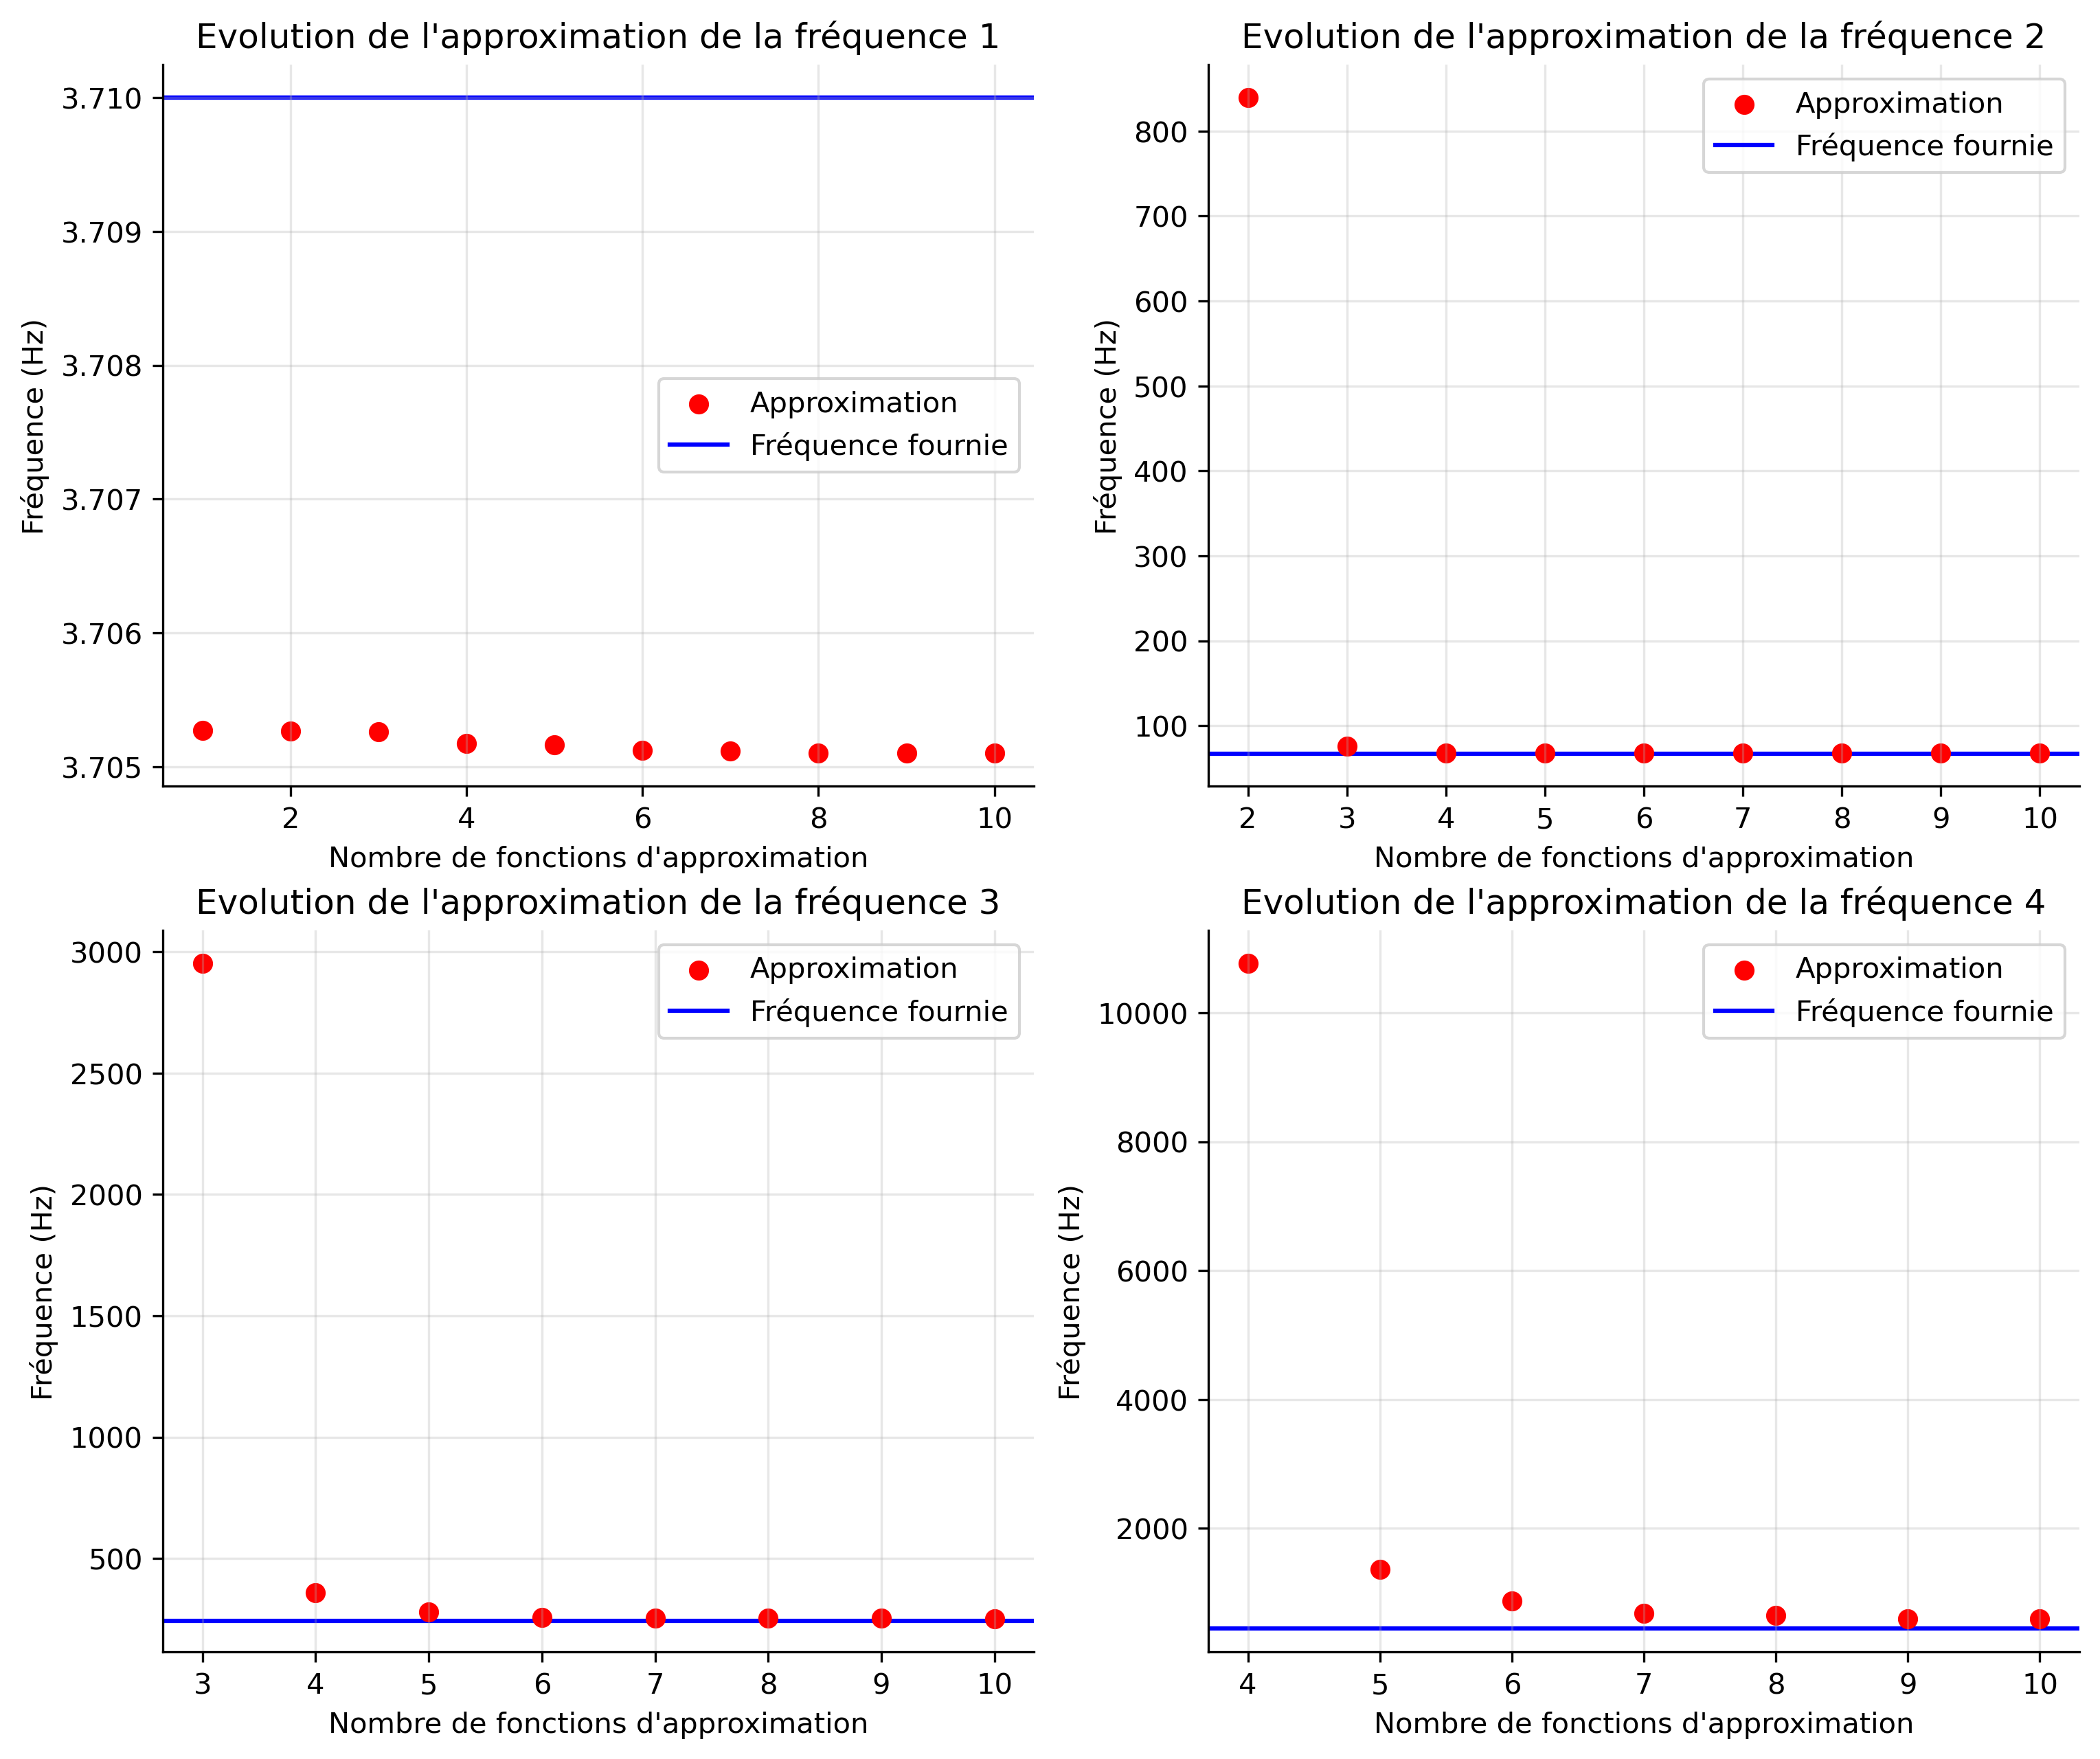

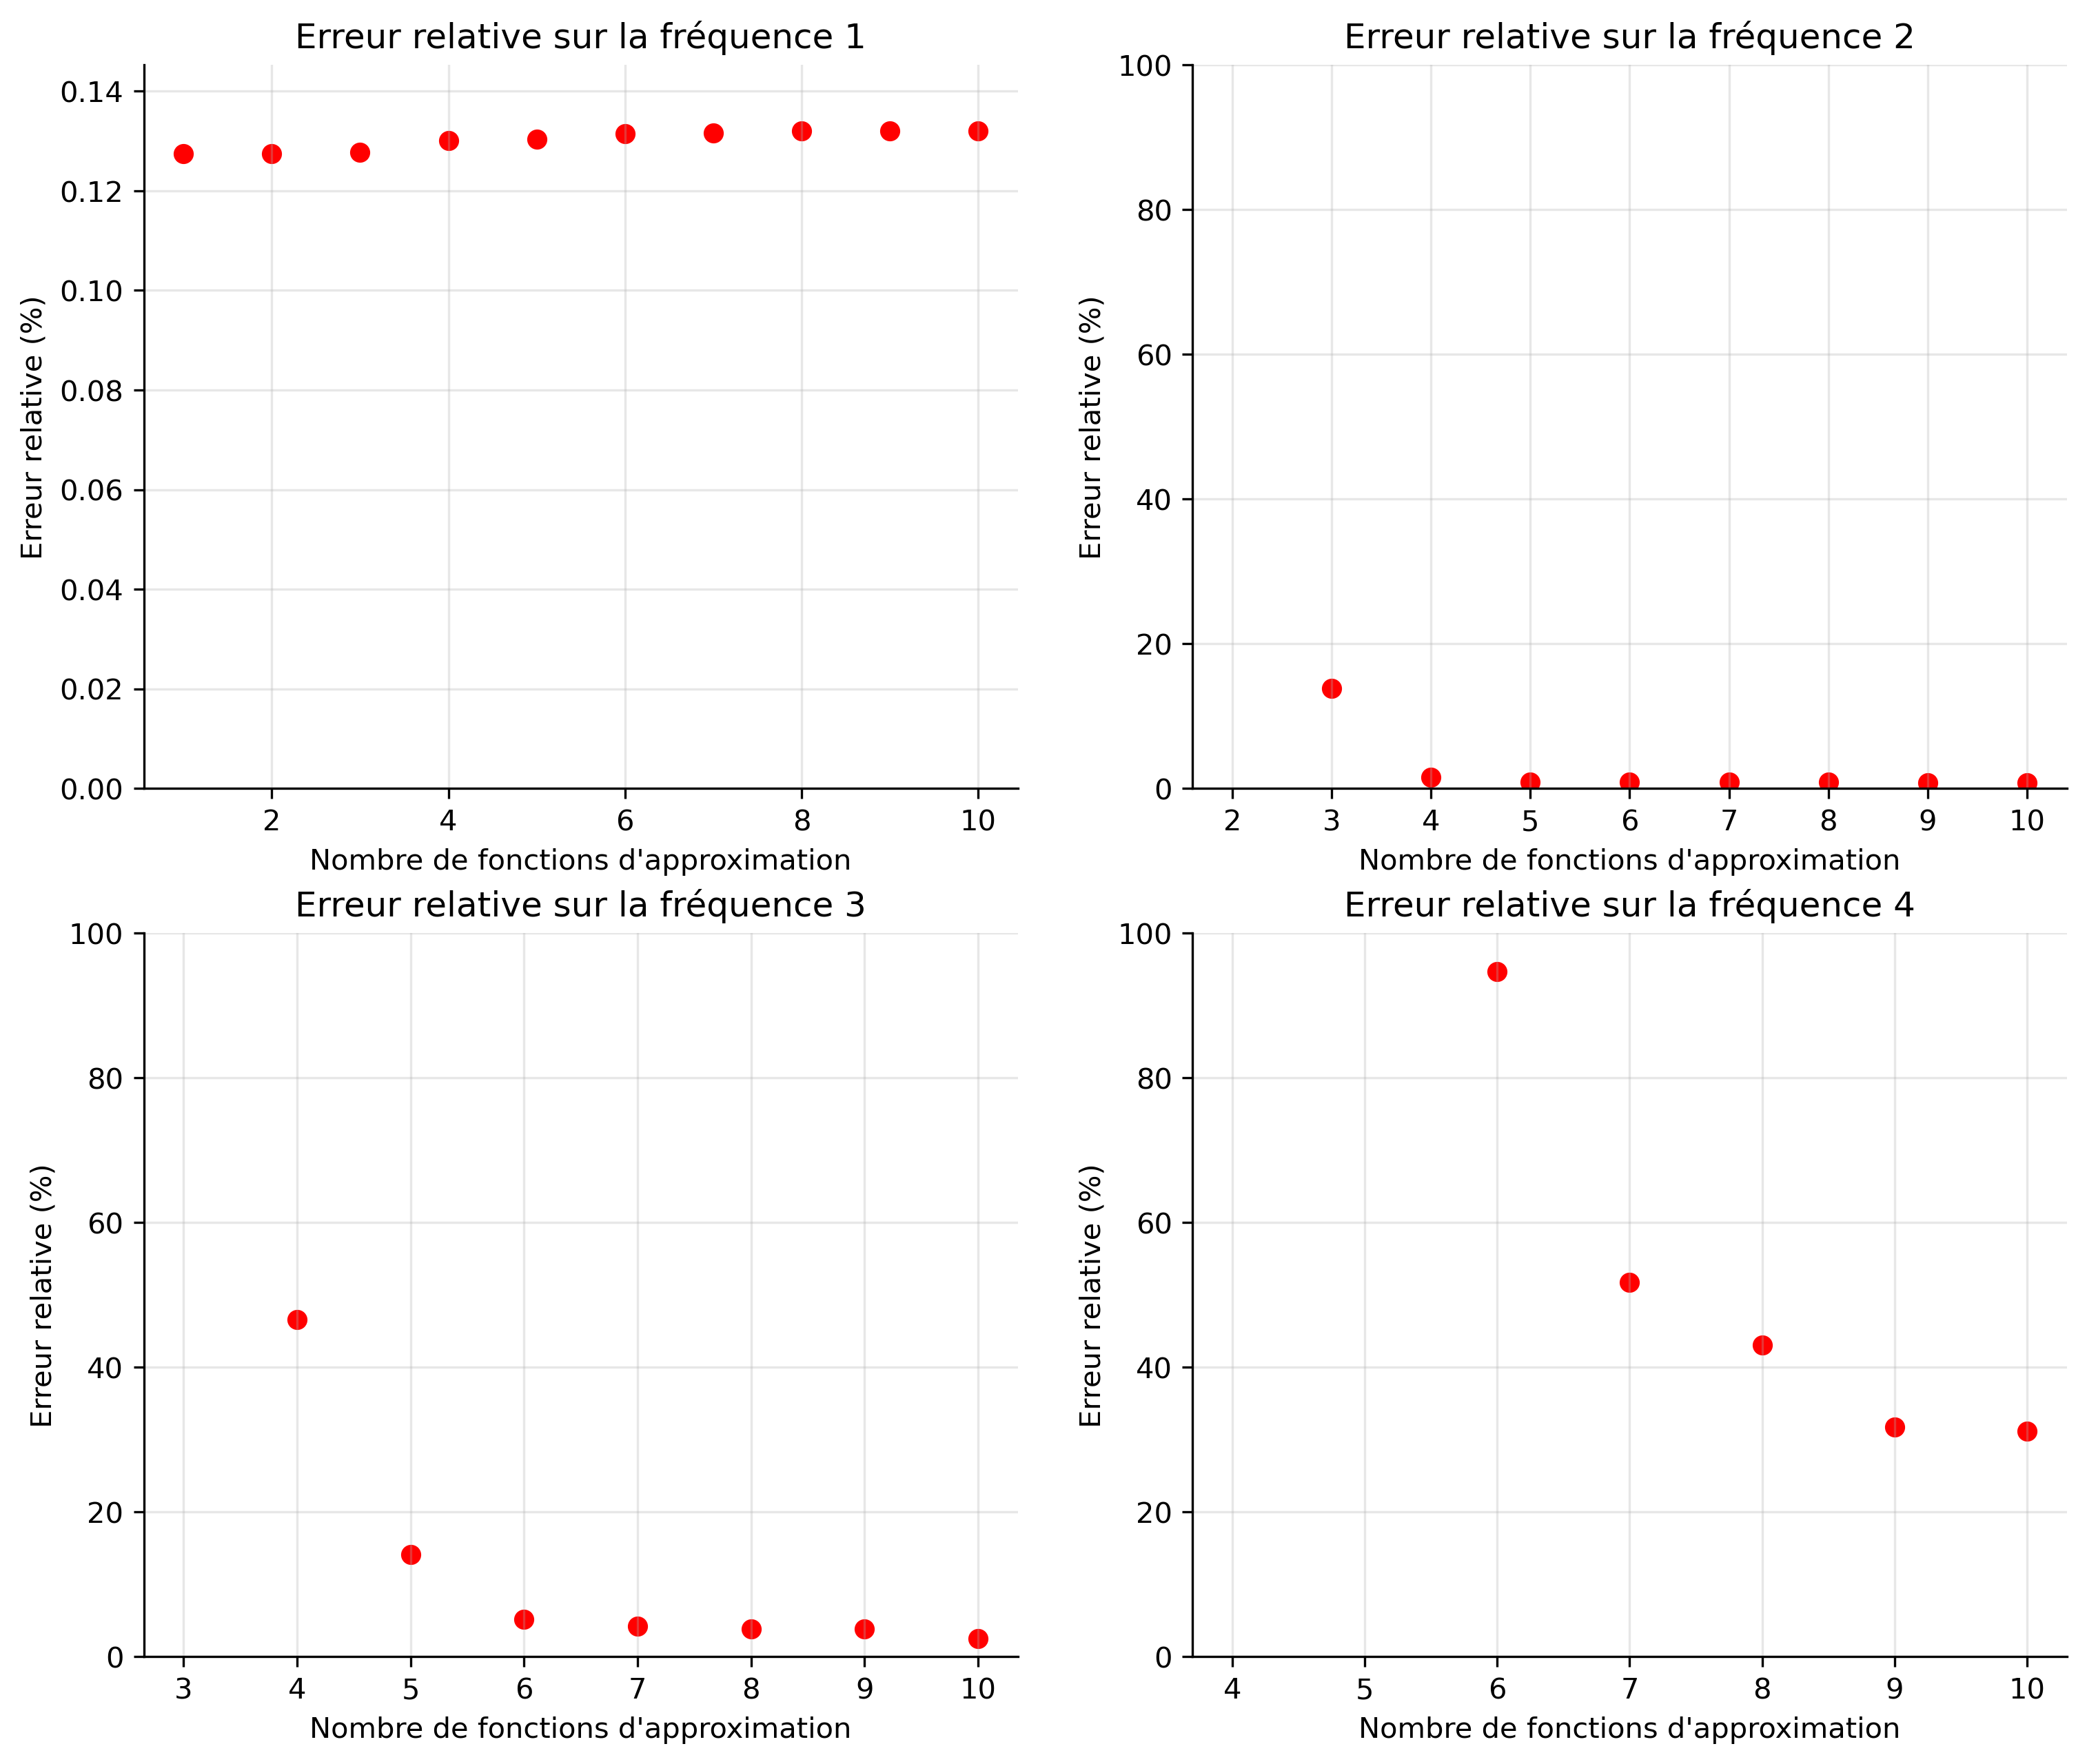

In [65]:
fig, ax_f = plt.subplots(2, 2, figsize=(12, 10), dpi=300)
fig2, ax_e = plt.subplots(2, 2, figsize=(12, 10), dpi=300)

for f in range(4):
    N_plot = np.linspace(N_min, N_max, N_max-N_min+1)

    ax_f[f//2][f % 2].scatter(N_plot, freq_matrix[:, f],
                              label=f'Approximation', color='r')

    ax_f[f//2][f % 2].axhline(y=nat_freq[f], color='blue',
                              zorder=0, label='Fréquence fournie')
    ax_f[f//2][f % 2].set_xlabel('Nombre de fonctions d\'approximation')
    ax_f[f//2][f % 2].set_ylabel('Fréquence (Hz)')
    ax_f[f//2][f %
               2].set_title(f"Evolution de l'approximation de la fréquence {f+1}")
    ax_f[f//2][f % 2].legend()
    ax_f[f//2][f % 2].grid(True, alpha=0.3)

    ax_f[f//2][f % 2].spines['top'].set_visible(False)
    ax_f[f//2][f % 2].spines['right'].set_visible(False)
    ax_f[f//2][f % 2].spines['left'].set_position(('outward', 0))
    ax_f[f//2][f % 2].spines['bottom'].set_position(('outward', 0))

    ax_e[f//2][f % 2].scatter(N_plot, error_matrix[:, f],
                              label=f'Fréquence {f+1}', color='r')
    ax_e[f//2][f % 2].set_xlabel('Nombre de fonctions d\'approximation')
    ax_e[f//2][f % 2].set_ylabel('Erreur relative (%)')
    ax_e[f//2][f % 2].set_ylim(0, min(1.1 * max(error_matrix[:, f]), 100))

    ax_e[f//2][f % 2].set_title(f"Erreur relative sur la fréquence {f+1}")
    ax_e[f//2][f % 2].grid(True, alpha=0.3)
    ax_e[f//2][f % 2].spines['top'].set_visible(False)
    ax_e[f//2][f % 2].spines['right'].set_visible(False)
    ax_e[f//2][f % 2].spines['left'].set_position(('outward', 0))
    ax_e[f//2][f % 2].spines['bottom'].set_position(('outward', 0))
fig.savefig('Plots/P4_freq_approx_2_2.png')
fig2.savefig('Plots/P4_error_approx_2_2.png')

---

# Calcul des modes 

Fonction pour calcul des modes apd des coeff

In [66]:
def modeshape(m, N, q, length, npoints):
    """
    Arguments :
        m = mode d'intéret
        N = nombre de modes
        q = matrice des coefficients de chaque mode
        length = longueur de la poutre
        npoints = nombre de points à calculer
    Returns :
        W = déformation du mode m, normalisée tq W[0] = 1
    """

    X = np.linspace(0, length, npoints, endpoint=True)
    W = np.zeros(npoints)
    for i in range(0, N):
        for j in range(0, npoints):
            W[j] = W[j] + q[i, m] * phi(X[j], i)

    W = W/W[0]
    return W

Calcul et plot des modes

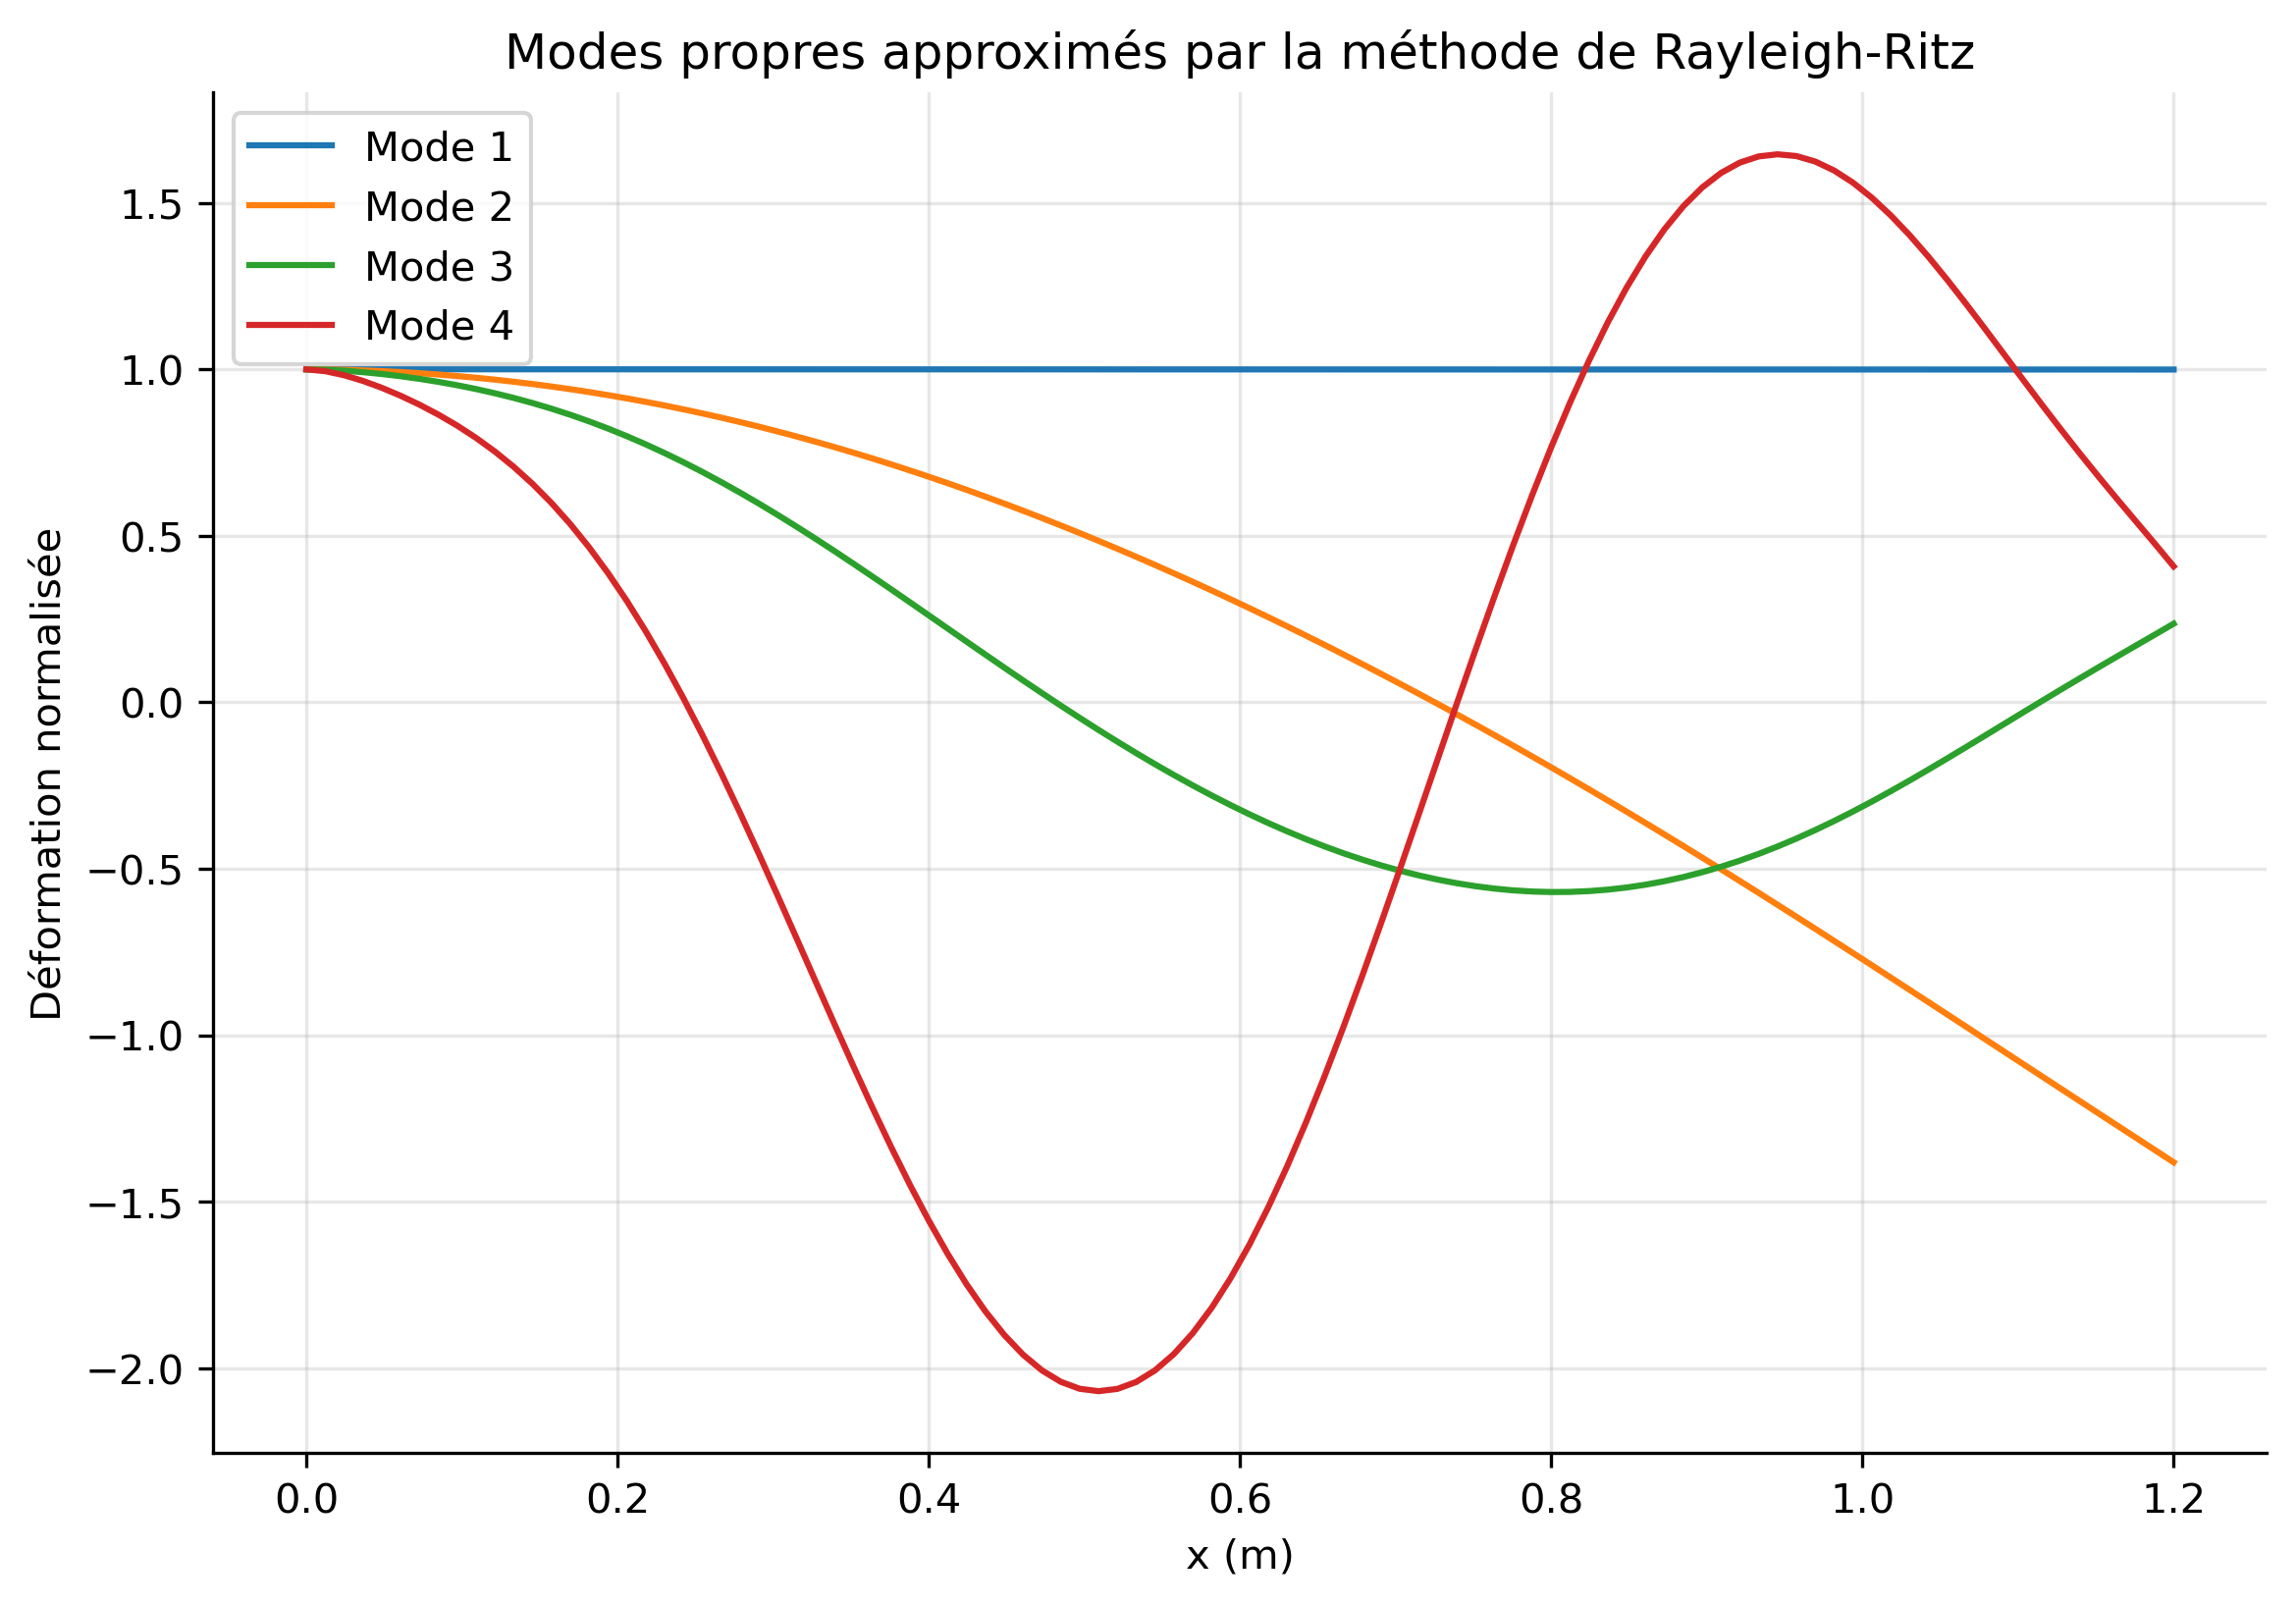

In [67]:
# Parametres
N_rr = 10

fig, ax = plt.subplots(1, 1, figsize=(9, 6), dpi=300)

nb_points = 100
x_plot_mode = np.linspace(0, length, nb_points)

M = Mass(N_rr)
K = Stiff(N_rr)
freq, q = eig(K, M)


sorted_indices = np.argsort(np.abs(np.sqrt(freq)))
q = q[:, sorted_indices]

U_ritz = np.zeros((4, nb_points))
for m in range(0, 4):
    U_ritz[m, :] = modeshape(m, N_rr, q, length, nb_points)  # m-ieme mode

    ax.plot(x_plot_mode, U_ritz[m, :], label=f"Mode {m+1}")
ax.grid(True, alpha=0.3)
ax.set_xlabel('x (m)')
ax.set_ylabel('Déformation normalisée')
ax.legend()
ax.set_title("Modes propres approximés par la méthode de Rayleigh-Ritz")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 0))
ax.spines['bottom'].set_position(('outward', 0))

fig.savefig('Plots/P4_modes_RR.png', dpi=300)

Comparaison approx vs vrais modes 

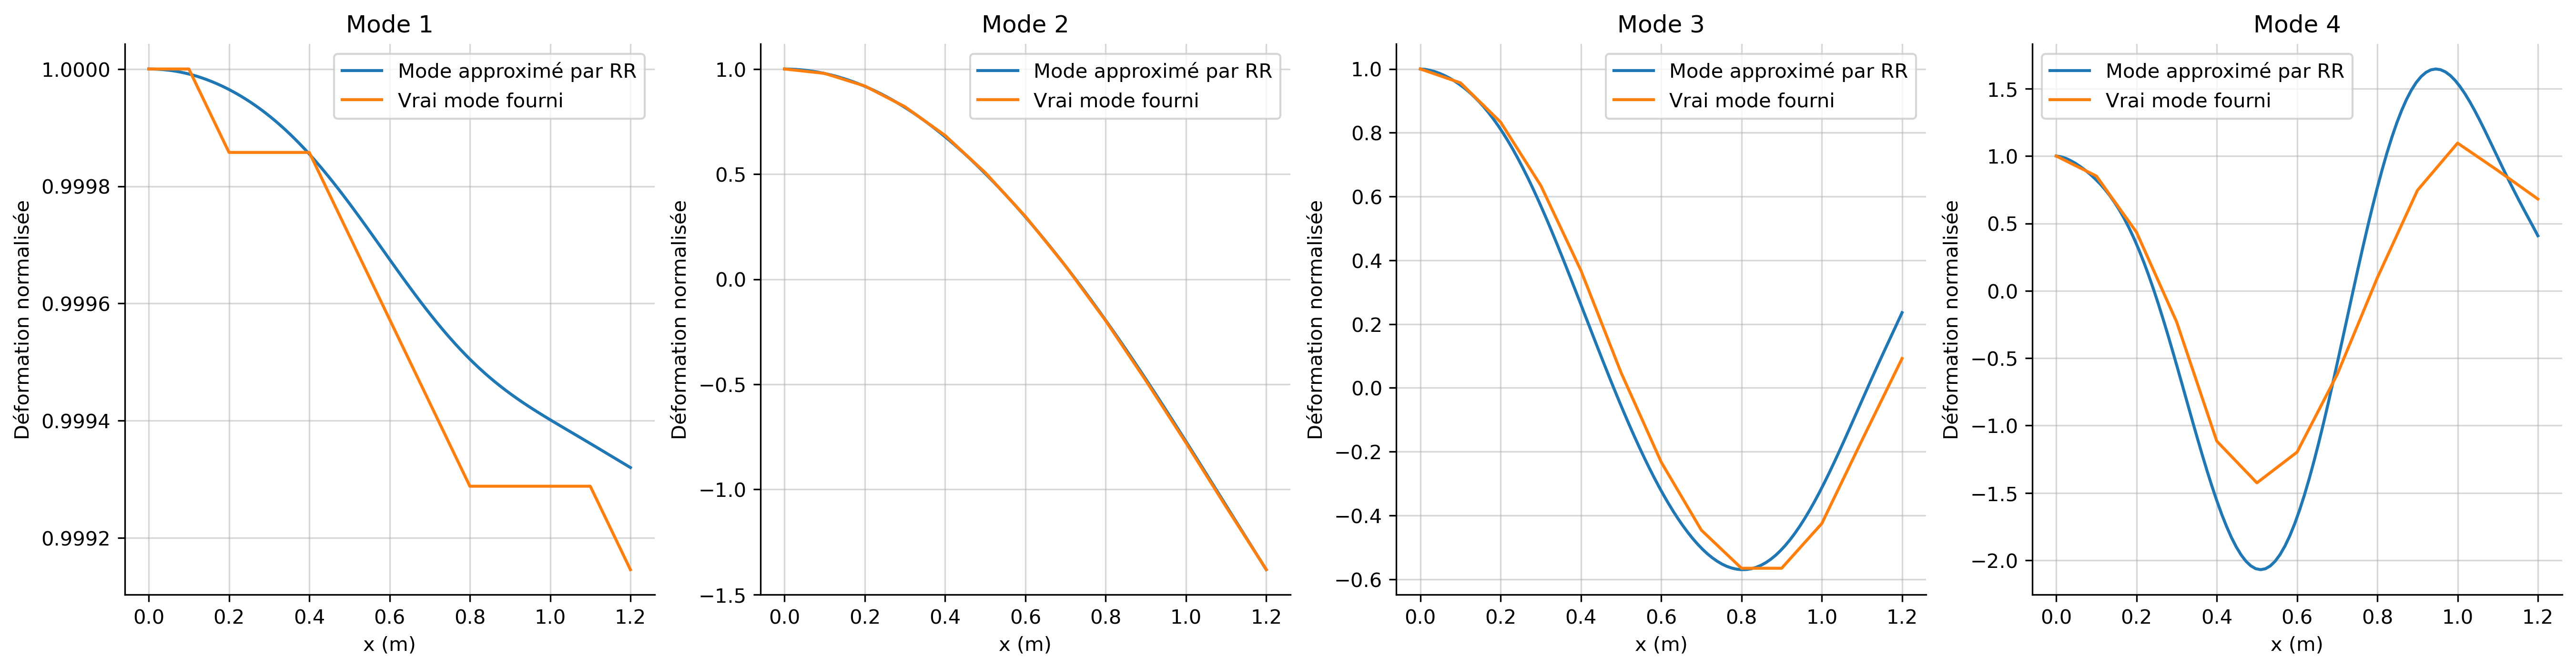

In [ ]:
# on reprend les modes approx U_ritz[:,m] calculés dans la cellule précédente

x_plot_data = np.linspace(0, length, 13)  # points tous les 0.1m
x_plot_data = np.insert(x_plot_data, 4, 0.4)  # on ajoute le moteur


fig, ax = plt.subplots(1, 4, figsize=(22, 5), dpi=300)
modes_simu = np.zeros_like(modes_data)
for m in range(0, 4):

    ax[m].plot(x_plot_mode, U_ritz[m, :], label="Mode approximé par RR")

    modes_simu[:, m] = modes_data[:, m]/modes_data[0, m]
    ax[m].plot(x_plot_data, modes_simu[:, m], label=f"Vrai mode fourni")
    ax[m].legend()
    ax[m].set_title(f"Mode {m+1}")
    ax[m].set_xlabel("x (m)")
    ax[m].set_ylabel("Déformation normalisée")
    ax[m].grid(True, alpha=0.5)

    ax[m].spines['top'].set_visible(False)
    ax[m].spines['right'].set_visible(False)
    ax[m].spines['left'].set_position(('outward', 0))
    ax[m].spines['bottom'].set_position(('outward', 0))

fig.savefig('Plots/P4_modes_compare.png', dpi=300)

---

# Matrice MAC

Calcul des modes via RR ( idem que section précédente)

In [69]:
N_rr = 10

nb_points = 13

M = Mass(N_rr)
K = Stiff(N_rr)
freq, q = eig(K, M)
sorted_indices = np.argsort(np.abs(np.sqrt(freq)))
q = q[:, sorted_indices]

phi_ritz = np.zeros((4, nb_points))

for m in range(0, 4):
    phi_ritz[m, :] = modeshape(m, N_rr, q, length, nb_points)  # m-ieme mode

Modes donnés

In [70]:
phi_simu = np.zeros((len(modes_data[0]), len(modes_data)))

for m in range(0, 4):
    phi_simu[m, :] = modes_data[:, m] / modes_data[0, m]
    phi_simu[m, :len(phi_simu[m]) - 1] = np.delete(phi_simu[m, :], 4)

phi_simu = phi_simu[:, :-1]

Calcul de la matrice MAC

In [71]:
mac_matrix = np.zeros((4, 4))



for m1 in range(4):


    for m2 in range(4):


        mac_matrix[m1, m2] = (np.abs(np.dot(phi_ritz[m1], phi_simu[m2]))**2 /


                              (np.dot(phi_ritz[m1], phi_ritz[m1]) * np.dot(phi_simu[m2], phi_simu[m2])))



# m1 le premier axe, les approx, les lignes


# m2 le deuxième axe, les vrais modes, les colonnes



mac_matrix

array([[1.        , 0.01703726, 0.0424389 , 0.01112682],
       [0.01718174, 0.99998376, 0.49393777, 0.1046609 ],
       [0.04380266, 0.36311271, 0.97899107, 0.08516116],
       [0.00446823, 0.14594861, 0.00212311, 0.92118587]])

Plot de la MAC matrix

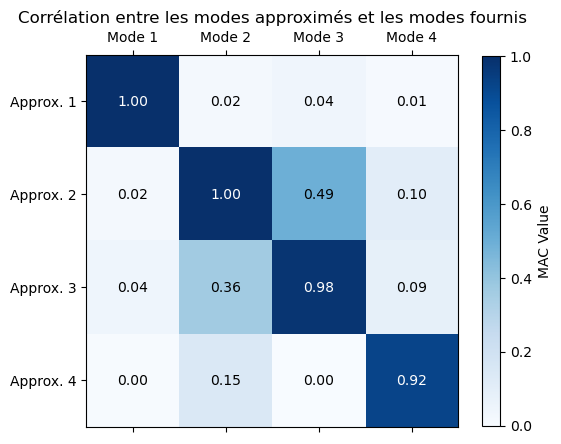

In [72]:
fig, ax = plt.subplots(figsize=(6, 6))
cax = ax.matshow(mac_matrix, cmap='Blues', vmin=0, vmax=1)

x_labels = ['Mode 1', 'Mode 2', 'Mode 3', 'Mode 4']
y_labels = ['Approx. 1', 'Approx. 2', 'Approx. 3', 'Approx. 4']


# Ajouter des étiquettes personnalisées aux axes
ax.set_xticks(np.arange(len(x_labels)))
ax.set_yticks(np.arange(len(y_labels)))
ax.set_xticklabels(x_labels)
ax.set_yticklabels(y_labels)


# Add colorbar
cbar = fig.colorbar(cax, shrink=0.8)
cbar.set_label('MAC Value')

# Add values to each cell
for (i, j), value in np.ndenumerate(mac_matrix):
    ax.text(j, i, f'{value:.2f}', ha='center', va='center',
            color='white' if value > 0.5 else 'black')

ax.set_title("Corrélation entre les modes approximés et les modes fournis")

fig.savefig('Plots/P4_MAC.png', dpi=300)

---

---